# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

In [1]:
from collections import deque, namedtuple
from unityagents import UnityEnvironment
from dqn_agent import Agent
import numpy as np

import torch

import matplotlib.pyplot as plt
%matplotlib inline

# Training Function

The function is used to train the Agent by interacting with environment and returns the training score. The training is considered to be completed once the Agent achieves a **score > 13.0**.

In [2]:
def train_dqn(n_episodes=2000, max_t=1000, eps_start=1., eps_end=0.01, eps_decay=0.99):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    avg_scores = []                    # list containing average scores
    std_scores = []                    # list containing std scores
    scores_window = deque(maxlen=100)  # last 100 scores
    
    eps = eps_start                    # initialize epsilon
    
    for i_episode in range(1, n_episodes+1):
        state = env.reset(train_mode=True)[brain_name].vector_observations[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)                      # Choose Action based on State
            env_info = env.step(action)[brain_name]             # Send Action to Environment
            next_state = env_info.vector_observations[0]        # Get the Next State
            reward = env_info.rewards[0]                        # Get the Reward
            done = env_info.local_done[0]                       # Identify if Terminal State is reached
            agent.step(state, action, reward, next_state, done) # Incorporate Environment Feedback to Agent
            state = next_state
            score += reward
            if done:
                break
                
        scores_window.append(score)                 # Save score to Last-100 List
        scores.append(score)                        # Save score from episode
        avg_scores.append(np.mean(scores_window))   # Save Average Scores
        std_scores.append(np.std(scores_window))    # Save Average Scores
        
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100,
                                                                                         np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores, avg_scores, std_scores

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="Banana.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# Get the Default Brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [5]:
# Reset the Environment
env_info = env.reset(train_mode=True)[brain_name]

# Number of Agents in the Environment
print('Number of agents:', len(env_info.agents))

# Number of Actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# Examine the State Space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Train the Agent

The cell trains the DQN Agent by utilizing a **RainbowDQN** that contains the following techniques:

- Double DQN
- Duel DQN
- Prioritized Experience Replay

After the cell is executed, the Agent is trained and the scores of the training are being return for plotting.

In [6]:
# Initialize Deep Q-Network Agent
agent = Agent(state_size = state_size, action_size = action_size, seed = 0,
              double_dqn = True, duel_dqn = True, prio_exp = True)

scores, avg_scores, std_scores = train_dqn(n_episodes = 600)

Episode 100	Average Score: 1.85
Episode 200	Average Score: 8.98
Episode 300	Average Score: 11.84
Episode 332	Average Score: 13.02
Environment solved in 232 episodes!	Average Score: 13.02


### 4. Plot Agent Scores

The cell below plot the **Scores** and the **Average Scores** that Agent achieved per Episode during training.

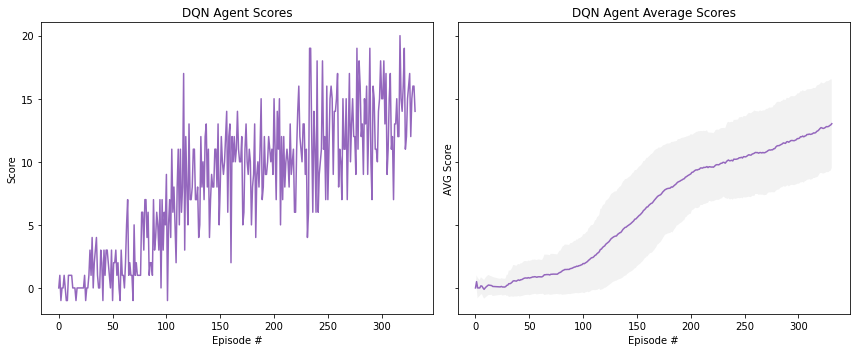

In [18]:
# Transform to Array
scores = np.array(scores)
avg_scores = np.array(avg_scores)
std_scores = np.array(std_scores)

# Initiate Figure
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# Plot Agent Scores
ax1.plot(np.arange(len(scores)), scores, color = 'tab:purple')
ax1.set_ylabel('Score')
ax1.set_xlabel('Episode #')
ax1.set_title('DQN Agent Scores')

ax2.plot(np.arange(len(avg_scores)), avg_scores, color = 'tab:purple')
ax2.fill_between(np.arange(len(avg_scores)), avg_scores+std_scores, avg_scores-std_scores,
                 facecolor='gray', alpha=0.1)
ax2.set_ylabel('AVG Score')
ax2.set_xlabel('Episode #')
ax2.set_title('DQN Agent Average Scores')

f.tight_layout()

In [6]:
env.close()

When finished, you can close the environment.

# Test the Trained Agent

In [5]:
# Check if the Environment is Active
try:
    env
except:
    UnityEnvironment(file_name="Banana.app")

# Get the Default Brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# Reset Environment & Deactivate Training
env_info = env.reset(train_mode=False)[brain_name]
action_size = brain.vector_action_space_size
state = env_info.vector_observations[0]
state_size = len(state)

# Initialize the DQN Agent
agent = Agent(state_size=state_size, action_size=action_size, seed=0,
             double_dqn = True, duel_dqn = True, prio_exp = True)

# Load the Trained model
state_dict = torch.load('checkpoint.pth')
agent.qnetwork_local.load_state_dict(state_dict)
agent.qnetwork_local.eval()

n_episodes = 10        # Number of episodes in the test
max_t = 1000           # Number of max timesteps per episode in the test
agent_scores = []      # List to store Agent's Scores
agent_avg_scores = []  # List to store Agent's Average Scores

# Interact Agent with the Enviornment
for i_episode in range(1, n_episodes+1):
    state = env.reset(train_mode=False)[brain_name].vector_observations[0]
    score = 0
    for t in range(max_t):
        action = agent.act(state)
        env_info = env.step(action)[brain_name]        # Send Action to the Environment
        next_state = env_info.vector_observations[0]   # Get the Next State
        reward = env_info.rewards[0]                   # Get the Reward
        done = env_info.local_done[0]                  # See if episode has Finished
        state = next_state
        score += reward
        print('\rEpisode {}\Score: {:.2f}'.format(i_episode, score), end="")
        if done:
            break 

    agent_scores.append(score)
    agent_avg_scores.append(np.mean(score))

    print('\rEpisode {}\Score: {:.2f}'.format(i_episode, agent_scores[-1]))

Episode 1\Score: 14.00
Episode 2\Score: 1.00
Episode 3\Score: 13.00
Episode 4\Score: 18.00
Episode 5\Score: 13.00
Episode 6\Score: 16.00
Episode 7\Score: 0.00
Episode 8\Score: 18.00
Episode 9\Score: 15.00
Episode 10\Score: 16.00
